In [1]:
!pip install datasets evaluate transformers[sentencepiece]

In [2]:
pip install transformers

In [3]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [4]:
import tensorflow as tf
import re

print("Running TensorFlow version ",tf.__version__)

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.14.0
Version 2, minor 14


In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [6]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow import keras
from sklearn.model_selection import train_test_split
from transformers import pipeline
from transformers import TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, TFDistilBertModel
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import AutoTokenizer, DataCollatorWithPadding
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import layers
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# ***1. Exploratory Data Analysis (EDA)***

Exploratory Data Analysis (EDA) is an essential step in data analysis and it allows us to understand the data, identify patterns and anomalies and decide on the appropriate analysis or predictive modeling techniques to use.

The "sentences_allagree" flavor is used in this project and the dataset statistics is summarized. Furthermore, data cleaning and visualization is also conducted in this part.

In [7]:
# import the dataset
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')['train']

In [8]:
ds = pd.DataFrame(dataset)
ds.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In the above dataframe, Label 0 means negative, Label 1 means neutral and Lable 2 means positive. Next, this project will mark the sentiment for each sentence.

In [9]:
sentiment = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

In [10]:
ds["sentiment"] = ds["label"].map(sentiment)
ds.head()

,sentence,label,sentiment
0,"According to Gran , the company has no plans t...",1,Neutral
1,"For the last quarter of 2010 , Componenta 's n...",2,Positive
2,"In the third quarter of 2010 , net sales incre...",2,Positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,Positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,Positive


## **1.1 Data Cleaning**
Check for the missing values

In [11]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   2264 non-null   object
 1   label      2264 non-null   int64 
 2   sentiment  2264 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.2+ KB


There is no missing value in this dataset.

Drop duplicated sentences

In [12]:
ds["sentence"].drop_duplicates()
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   2264 non-null   object
 1   label      2264 non-null   int64 
 2   sentiment  2264 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.2+ KB


There is no duplicated sentence in this dataset.

## **1.2 Summary Statistics**

In [13]:
ds['sentiment'].value_counts()

Neutral     1391
Positive     570
Negative     303
Name: sentiment, dtype: int64

The sentiment "Neutral" the most, exceeding the sum of the other two.

In [14]:
ds.describe()

,label
count,2264.000000
mean,1.117933
std,0.609801
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


## **1.3 Data Visualization**

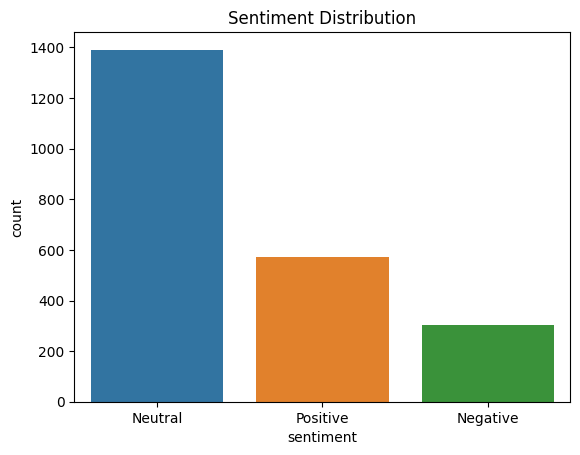

In [15]:
# bar plot
sentiment_counts = ds['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.title('Sentiment Distribution')
plt.show()

In [16]:
positive_sentences = ' '.join(ds[ds['sentiment'] == 'Positive']['sentence'])
neutral_sentences = ' '.join(ds[ds['sentiment'] == 'Neutral']['sentence'])
negative_sentences = ' '.join(ds[ds['sentiment'] == 'Negative']['sentence'])

In [17]:
# Display the Word Cloud
def create_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

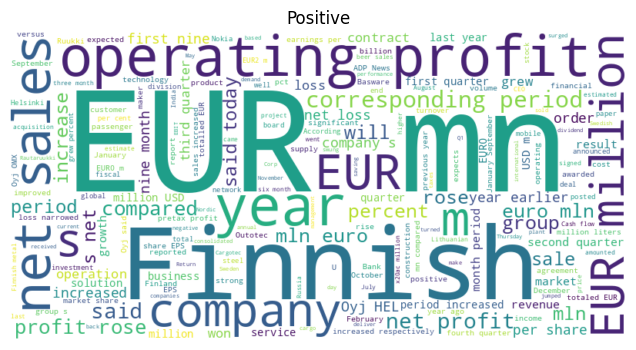

In [18]:
create_word_cloud(positive_sentences, "Positive")

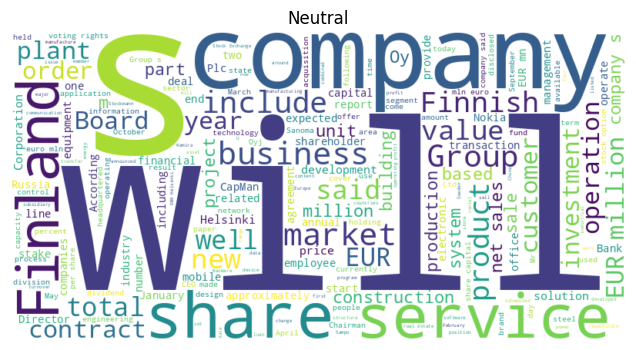

In [19]:
create_word_cloud(neutral_sentences, "Neutral")

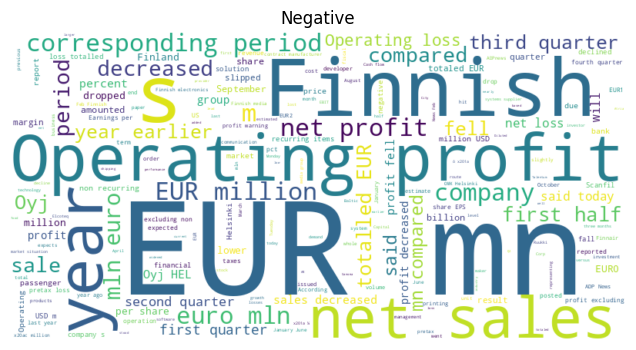

In [20]:
create_word_cloud(negative_sentences, "Negative")

# ***2. Data Preparation***

## **2.1 Define the Tokenizer**

In [21]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## **2.2 Train-Test-Valid Split and Tokenize the Data**




There are 5 features in this dataset: sentence, label, input_ids, token_type_ids and attention_mask.

Split the dataset into training, valid and test set. The proportions of training, valid and test set are 0.7, 0.15 and 0.15, respectively.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataset["sentence"], dataset["label"], test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

In [23]:
train_tokens = tokenizer(X_train, padding = True, truncation=True)
valid_tokens = tokenizer(X_valid, padding = True, truncation=True)
test_tokens = tokenizer(X_test, padding = True, truncation=True)

In [24]:
ds_train = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    y_train
))
ds_valid = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens),
    y_valid
))
ds_test = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    y_test
))

# ***3. Transfer Learning***

## **3.1 Fine-tuning Model with Head Only**

In [61]:
head_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
head_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_118 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model while freezing the weights of all layers except the head unchanged.

In this case, the classification head likely consists of the layers of pre_classifier, classifier, and dropout_39. Therefore, only the first layer need to be frozen.

In [62]:
head_model.layers[0].trainable = False

The choice of learning rate plays an important role in training neutral deep learning model. When I set the learning rate=0.001, the result of fine-tuning-all-layer model was very unsatisfactory.

To solve this problem, "tf.keras.optimizers.schedules.PolynomialDecay()" is used to implement a polynomial decay schedule for learning rates. This learning rate schedule adjusts the learning rate according to a polynomial decay function.

In [63]:
initial_learning_rate = 1e-5
decay_steps = len(ds_train)
end_learning_rate = 0.0
power = 0.5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power)

head_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [64]:
head_model.fit(
    ds_train.batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 15s 40ms/step - loss: 0.9637 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.9143 - val_sparse_categorical_accuracy: 0.5941
Epoch 2/5
198/198 [==============================] - 6s 29ms/step - loss: 0.8712 - sparse_categorical_accuracy: 0.6162 - val_loss: 0.8607 - val_sparse_categorical_accuracy: 0.5941
Epoch 3/5
198/198 [==============================] - 6s 28ms/step - loss: 0.8235 - sparse_categorical_accuracy: 0.6168 - val_loss: 0.8137 - val_sparse_categorical_accuracy: 0.5941
Epoch 4/5
198/198 [==============================] - 6s 29ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.7734 - val_sparse_categorical_accuracy: 0.6118
Epoch 5/5
198/198 [==============================] - 6s 28ms/step - loss: 0.7449 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.6559


In [40]:
def model_evaluation(model, test_data, true_data):
  loss, accuracy = model.evaluate(test_data.batch(5))
  print("\nModel Loss:", loss)
  print("\nModel Accuracy:", accuracy)

  prob = model.predict(test_data.batch(5))
  pred = np.argmax(prob["logits"], axis=1)
  matrix = confusion_matrix(true_data, pred)
  report = classification_report(true_data, pred)
  print(f"\n\nConfusion Matrix:\n{matrix}")
  print(f"\n\nClassification Report:\n{report}")

In [66]:
model_evaluation(head_model, ds_test, y_test)

68/68 [==============================] - 3s 16ms/step - loss: 0.7051 - sparse_categorical_accuracy: 0.6882

Model Loss: 0.7050716876983643

Model Accuracy: 0.6882352828979492
68/68 [==============================] - 3s 15ms/step


Confusion Matrix:
[[  0  33  12]
 [  0 213   0]
 [  0  61  21]]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.69      1.00      0.82       213
           2       0.64      0.26      0.37        82

    accuracy                           0.69       340
   macro avg       0.44      0.42      0.39       340
weighted avg       0.59      0.69      0.60       340



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **3.2 Fine-tuning All Layers**

In [67]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_138 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [69]:
model.fit(
    ds_train.batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 40s 103ms/step - loss: 0.5942 - sparse_categorical_accuracy: 0.7664 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9529
Epoch 2/5
198/198 [==============================] - 12s 62ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.1025 - val_sparse_categorical_accuracy: 0.9676
Epoch 3/5
198/198 [==============================] - 13s 63ms/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.1031 - val_sparse_categorical_accuracy: 0.9735
Epoch 4/5
198/198 [==============================] - 12s 62ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.1100 - val_sparse_categorical_accuracy: 0.9618
Epoch 5/5
198/198 [==============================] - 12s 62ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.1107 - val_sparse_categorical_accuracy: 0.9706


In [70]:
model_evaluation(model, ds_test, y_test)

68/68 [==============================] - 3s 15ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9559

Model Loss: 0.15581664443016052

Model Accuracy: 0.9558823704719543
68/68 [==============================] - 3s 15ms/step


Confusion Matrix:
[[ 40   0   5]
 [  0 208   5]
 [  3   2  77]]


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.99      0.98      0.98       213
           2       0.89      0.94      0.91        82

    accuracy                           0.96       340
   macro avg       0.94      0.93      0.93       340
weighted avg       0.96      0.96      0.96       340



## **3.3 Findings**

Training all the weights of a model, as opposed to only training the classification head, can lead to better performance. Here's why:

1. Learning Task-Specific Features: Pre-trained models are trained on general tasks (like language modeling) to learn a wide range of features from text. However, these features might not be perfectly aligned with the specifics of a new task. By fine-tuning all layers, the model can adjust these pre-learned features to better suit the specific requirements of the new task, leading to improved performance.

2. Deep Layers Capture Abstract Representations: In deep neural networks, earlier layers tend to learn more generic features (like edges in images, or common word patterns in text), while deeper layers learn more abstract, complex representations. By adjusting all layers, the model can fine-tune these complex representations to better fit the new task, which can be especially important for tasks that are substantially different from the original training task.

3. Adaptation to Domain-Specific Language: If the new task involves a specific type of language or jargon (such as legal, medical, or technical language), fine-tuning the entire model allows it to adjust to this domain-specific language, which the model might not have encountered during its initial pre-training.

4. Avoiding Overfitting in the Classification Head: If only the classification head is trained, there's a risk of overfitting it to the training data, especially if it's a relatively small dataset. The pre-trained layers provide a regularizing effect by offering a rich, pre-learned feature set.

5. Leveraging Transfer Learning More Effectively: The essence of transfer learning is to transfer knowledge from one domain to another. By adjusting all layers, you can more effectively leverage the knowledge the model has gained during pre-training, leading to a more nuanced adaptation to the new task.

## **Extra Part**


# ***4. Create (and fit the model with) a TensorFlow Dataset (TFDS)***

In [36]:
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')['train']

In [37]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [38]:
tokens = tokenizer(dataset["sentence"], padding=True, return_tensors="np")
labels = np.array(dataset["label"])

Convert HuggingFace dataset to TensorFlow Dataset

In [39]:
def convert_to_tfds(token, label):
  tfdataset = tf.data.Dataset.from_tensor_slices((
        dict(token),
        label
      ))
  return tfdataset
tf_dataset = convert_to_tfds(tokens, labels)

Shuffle and split the source dataset after turning it into a TFDS

In [40]:
shuffled_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))

In [41]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)

train_dataset = shuffled_dataset.take(train_size)
test_val_dataset = shuffled_dataset.skip(train_size)
val_dataset = test_val_dataset.take(val_size)
test_dataset = test_val_dataset.skip(val_size)

In [42]:
y_test_ = []

for features, label in test_dataset:
    y_test_.append(label.numpy())

In [43]:
len(y_test_)

341

In [44]:
del(shuffled_dataset)
del(tf_dataset)

## **4.1 Fine-tuning Model with Head Only**

In [45]:
head_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [46]:
head_model.layers[0].trainable = False

In [47]:
head_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    run_eagerly=True
)

In [48]:
head_model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(8),
    validation_data=val_dataset.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 56s 278ms/step - loss: 0.9621 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.8649 - val_sparse_categorical_accuracy: 0.6460
Epoch 2/5
198/198 [==============================] - 55s 277ms/step - loss: 0.8786 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.8288 - val_sparse_categorical_accuracy: 0.6342
Epoch 3/5
198/198 [==============================] - 54s 273ms/step - loss: 0.8352 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.8029 - val_sparse_categorical_accuracy: 0.6077
Epoch 4/5
198/198 [==============================] - 55s 276ms/step - loss: 0.7743 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6549
Epoch 5/5
198/198 [==============================] - 56s 282ms/step - loss: 0.7523 - sparse_categorical_accuracy: 0.6540 - val_loss: 0.6846 - val_sparse_categorical_accuracy: 0.7021


In [49]:
model_evaluation(head_model, test_dataset, y_test_)

69/69 [==============================] - 8s 118ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.6598

Model Loss: 0.7279080748558044

Model Accuracy: 0.6598240733146667
69/69 [==============================] - 7s 108ms/step


Confusion Matrix:
[[  0  46   5]
 [  0 187  29]
 [  0  70   4]]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.62      0.87      0.72       216
           2       0.11      0.05      0.07        74

    accuracy                           0.56       341
   macro avg       0.24      0.31      0.26       341
weighted avg       0.41      0.56      0.47       341



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **4.2 Fine-tuning Model with All Layers**

In [50]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [51]:
model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    run_eagerly=True
)

In [54]:
model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(8),
    validation_data=val_dataset.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 83s 416ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.0173 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
198/198 [==============================] - 79s 400ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0108 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
198/198 [==============================] - 80s 402ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0072 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
198/198 [==============================] - 79s 398ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0127 - val_sparse_categorical_accuracy: 0.9971
Epoch 5/5
198/198 [==============================] - 79s 401ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 1.0000


In [56]:
prob = model.predict(test_dataset.batch(8))
pred = np.argmax(prob["logits"], axis=1)

43/43 [==============================] - 5s 114ms/step


In [57]:
len(pred)

341

In [58]:
model_evaluation(model, test_dataset, y_test_)

69/69 [==============================] - 8s 123ms/step - loss: 0.0077 - sparse_categorical_accuracy: 1.0000

Model Loss: 0.007745878305286169

Model Accuracy: 1.0
69/69 [==============================] - 8s 109ms/step


Confusion Matrix:
[[ 10  29  12]
 [ 27 125  64]
 [ 13  44  17]]


Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20        51
           1       0.63      0.58      0.60       216
           2       0.18      0.23      0.20        74

    accuracy                           0.45       341
   macro avg       0.34      0.33      0.34       341
weighted avg       0.47      0.45      0.46       341



**Conclusion**

The result of converting TFDS first is similar with the previous results. This can be considered as reasonable because the different data processing orders will liely to have the same result

# ***5. Create own Classification head***

Headless model:

In [71]:
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
class TextClassificationModel(tf.keras.Model):
    def __init__(self, encoder, num_classes, train_encoder=True):
        super().__init__()
        self.encoder = encoder
        self.encoder.trainable = train_encoder
        self.dropout1 = Dropout(0.1)
        self.dense1 = Dense(50, activation="relu")
        self.dropout2 = Dropout(0.1)
        self.classifier = Dense(num_classes)

    def call(self, inputs):
        x = self.encoder(inputs)
        x = x['last_hidden_state'][:, 0, :]
        x = self.dropout1(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        return self.classifier(x)

The output of TFDistilBertModel is used for classification tasks as it's designed to aggregate the context of the entire sequence. The TextClassificationModel adds layers on the output to adapt it for a specific classification task.

The first dense layer reduces the dimensionality to a manageable size for classification, while the final dense layer outputs the logits for each class.

In [73]:
new_head_model = TextClassificationModel(model, 3, train_encoder=False)

In [74]:
new_head_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [75]:
new_head_model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(8),
    validation_data=val_dataset.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 15s 39ms/step - loss: 0.9961 - sparse_categorical_accuracy: 0.5593 - val_loss: 0.8898 - val_sparse_categorical_accuracy: 0.6372
Epoch 2/5
198/198 [==============================] - 6s 31ms/step - loss: 0.9216 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.6313
Epoch 3/5
198/198 [==============================] - 6s 32ms/step - loss: 0.8913 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.8386 - val_sparse_categorical_accuracy: 0.6372
Epoch 4/5
198/198 [==============================] - 6s 31ms/step - loss: 0.8673 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.8742 - val_sparse_categorical_accuracy: 0.5752
Epoch 5/5
198/198 [==============================] - 6s 31ms/step - loss: 0.8374 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.8405 - val_sparse_categorical_accuracy: 0.5870


In [76]:
new_head_model.summary()

Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_1 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 dropout_158 (Dropout)       multiple                  0         
                                                                 
 dense (Dense)               multiple                  38450     
                                                                 
 dropout_159 (Dropout)       multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  153       
                                                                 
Total params: 66401483 (253.30 MB)
Trainable params: 38603 (150.79 KB)
Non-trainable params: 66362880 (253.

In [77]:
loss, accuracy = new_head_model.evaluate(test_dataset.batch(8))
print("\nModel Loss:", loss)
print("\nModel Accuracy:", accuracy)

43/43 [==============================] - 1s 24ms/step - loss: 0.8116 - sparse_categorical_accuracy: 0.6246

Model Loss: 0.8115856647491455

Model Accuracy: 0.6246334314346313


In [78]:
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
new_head_model_all_layers = TextClassificationModel(model, 3, train_encoder=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [79]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
new_head_model_all_layers.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [80]:
new_head_model_all_layers.fit(
    train_dataset.shuffle(len(train_dataset)).batch(8),
    validation_data=val_dataset.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 41s 106ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.7973 - val_loss: 0.1947 - val_sparse_categorical_accuracy: 0.9440
Epoch 2/5
198/198 [==============================] - 14s 72ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9912
Epoch 3/5
198/198 [==============================] - 13s 65ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.0201 - val_sparse_categorical_accuracy: 0.9912
Epoch 4/5
198/198 [==============================] - 13s 66ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0195 - val_sparse_categorical_accuracy: 0.9971
Epoch 5/5
198/198 [==============================] - 13s 65ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0051 - val_sparse_categorical_accuracy: 1.0000


In [81]:
new_head_model_all_layers.summary()

Model: "text_classification_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_2 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 dropout_179 (Dropout)       multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  38450     
                                                                 
 dropout_180 (Dropout)       multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  153       
                                                                 
Total params: 66401483 (253.30 MB)
Trainable params: 66401483 (253.30 MB)
Non-trainable params: 0 (0.00 B

In [82]:
loss, accuracy = new_head_model_all_layers.evaluate(test_dataset.batch(8))
print("\nModel Loss:", loss)
print("\nModel Accuracy:", accuracy)

43/43 [==============================] - 1s 23ms/step - loss: 0.0041 - sparse_categorical_accuracy: 1.0000

Model Loss: 0.0040818811394274235

Model Accuracy: 1.0


**Conclusion**

When creating own classificatino head, the model accuracies are 0.64 and 0.99, respectively, which is a little higher than auto generated model.

# ***6. Use Different "flavors" of the Dataset***

sentences_50agree

sentences_66agree

sentences_75agree

In [83]:
dataset_50 = load_dataset('financial_phrasebank', 'sentences_50agree')['train']
#dataset_66 = load_dataset('financial_phrasebank', 'sentences_66agree')['train']
#dataset_75 = load_dataset('financial_phrasebank', 'sentences_75agree')['train']

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [84]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(dataset_50["sentence"], dataset_50["label"], test_size=0.3)
X_test_50, X_valid_50, y_test_50, y_valid_50 = train_test_split(X_test_50, y_test_50, test_size=0.5)

In [85]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [86]:
train_tokens_50 = tokenizer(X_train_50, padding = True, truncation=True)
valid_tokens_50 = tokenizer(X_valid_50, padding = True, truncation=True)
test_tokens_50 = tokenizer(X_test_50, padding = True, truncation=True)

In [87]:
ds_train_50 = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens_50),
    y_train_50
))
ds_valid_50 = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens_50),
    y_valid_50
))
ds_test_50 = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens_50),
    y_test_50
))

## **6.1 Fine-tuning Model with Head Only**

In [91]:
head_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [92]:
head_model.layers[0].trainable = False

In [93]:
initial_learning_rate = 1e-5
decay_steps = len(ds_train_50)
end_learning_rate = 0.0
power = 0.5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power)

head_model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [94]:
head_model.fit(
    ds_train_50.batch(8),
    validation_data=ds_valid_50.batch(8),
    epochs=5
)

Epoch 1/5
424/424 [==============================] - 20s 32ms/step - loss: 0.9619 - sparse_categorical_accuracy: 0.5587 - val_loss: 0.8857 - val_sparse_categorical_accuracy: 0.6080
Epoch 2/5
424/424 [==============================] - 12s 28ms/step - loss: 0.8820 - sparse_categorical_accuracy: 0.5881 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.6080
Epoch 3/5
424/424 [==============================] - 12s 28ms/step - loss: 0.8446 - sparse_categorical_accuracy: 0.6005 - val_loss: 0.8100 - val_sparse_categorical_accuracy: 0.6176
Epoch 4/5
424/424 [==============================] - 12s 29ms/step - loss: 0.8148 - sparse_categorical_accuracy: 0.6315 - val_loss: 0.7828 - val_sparse_categorical_accuracy: 0.6355
Epoch 5/5
424/424 [==============================] - 12s 29ms/step - loss: 0.7905 - sparse_categorical_accuracy: 0.6468 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.6437


In [95]:
model_evaluation(head_model, ds_test_50, y_test_50)

146/146 [==============================] - 4s 16ms/step - loss: 0.7515 - sparse_categorical_accuracy: 0.6630

Model Loss: 0.75149005651474

Model Accuracy: 0.662998616695404
146/146 [==============================] - 4s 15ms/step


Confusion Matrix:
[[  0  50  37]
 [  0 434   8]
 [  0 150  48]]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.68      0.98      0.81       442
           2       0.52      0.24      0.33       198

    accuracy                           0.66       727
   macro avg       0.40      0.41      0.38       727
weighted avg       0.56      0.66      0.58       727



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **6.2 Fine-tuning Model With All Layers**

In [96]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [97]:
model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [98]:
model.fit(
    ds_train_50.batch(8),
    validation_data=ds_valid_50.batch(8),
    epochs=5
)

Epoch 1/5
424/424 [==============================] - 56s 85ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.4396 - val_sparse_categorical_accuracy: 0.8294
Epoch 2/5
424/424 [==============================] - 27s 63ms/step - loss: 0.3236 - sparse_categorical_accuracy: 0.8777 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.8239
Epoch 3/5
424/424 [==============================] - 27s 63ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.4288 - val_sparse_categorical_accuracy: 0.8349
Epoch 4/5
424/424 [==============================] - 26s 62ms/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.4155 - val_sparse_categorical_accuracy: 0.8487
Epoch 5/5
424/424 [==============================] - 26s 62ms/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.4347 - val_sparse_categorical_accuracy: 0.8583


In [99]:
model_evaluation(model, ds_test_50, y_test_50)

146/146 [==============================] - 4s 15ms/step - loss: 0.4200 - sparse_categorical_accuracy: 0.8735

Model Loss: 0.42002207040786743

Model Accuracy: 0.8734525442123413
146/146 [==============================] - 4s 15ms/step


Confusion Matrix:
[[ 74   7   6]
 [ 11 392  39]
 [  4  25 169]]


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        87
           1       0.92      0.89      0.91       442
           2       0.79      0.85      0.82       198

    accuracy                           0.87       727
   macro avg       0.85      0.86      0.86       727
weighted avg       0.88      0.87      0.87       727



**Conclusion**

Fine-tuning model with all layers is still much better than fine-tuning with head only.

When using the favor 'sentences_50agree' of the dataset, the accuracy is 0.87, which is lower than that of 0.96 when using the favor 'sentences_allagree' of the dataset. This may sugget that the model is more suitable for the dataset of allagree sentences. The reason might be the 'sentences_50agree' leads to an overfiting problem for this model


# ***7. Address Any Imbalanced Data Issues***

As we have shown in the previous part, there are some imbalanced data issues for the labels:

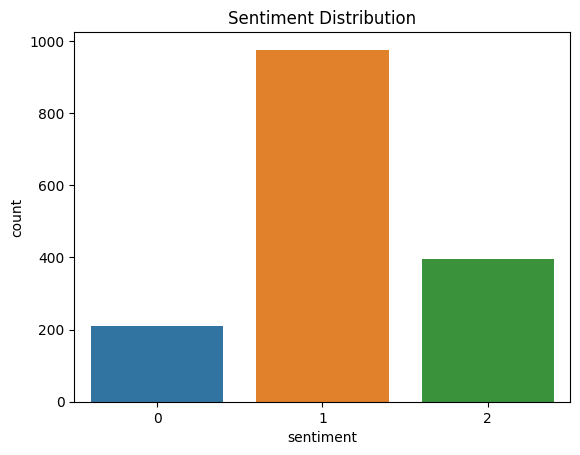

In [100]:
series = pd.Series(y_train)

sentiment_counts = series.value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.title('Sentiment Distribution')
plt.show()

The inbalanced data can lead to some model bias. As the model might tend to recognize the sentence as 'neutral'.

To address this problem, we can use some resampling techniques, such as random oversampling, which increases the number of instances in the minority class by randomly replicating them.

In [101]:
len(y_test)

340

(array([976.,   0.,   0.,   0.,   0., 976.,   0.,   0.,   0., 976.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

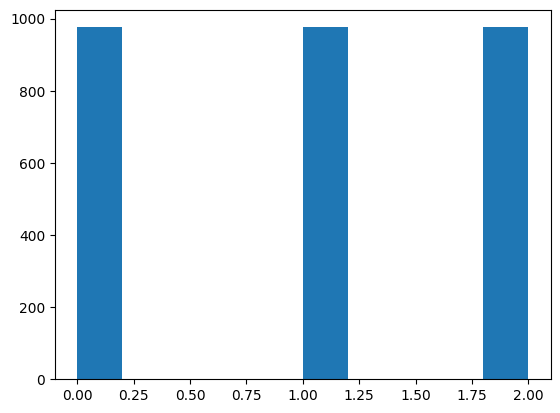

In [102]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)
X_train_res = list(map(lambda x: x[0], X_train_res))

plt.hist(y_train_res)

In [103]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
train_tokens_res = tokenizer(X_train_res, padding=True, truncation=True, return_tensors="np")
labels = np.array(labels)

In [104]:
ds_train_res = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens_res),
    np.array(y_train_res)
))

In [105]:
del X_train_res
del y_train_res

## **7.1 Fine-tuning with Head Only**

In [106]:
head_model_res = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [107]:
head_model_res.layers[0].trainable = False

In [108]:
initial_learning_rate = 1e-5
decay_steps = len(ds_train_res)
end_learning_rate = 0.0
power = 0.5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power)

head_model_res.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

head_model_res.fit(
    ds_train_res.shuffle(len(ds_train_res)).batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
366/366 [==============================] - 19s 32ms/step - loss: 1.0572 - sparse_categorical_accuracy: 0.4918 - val_loss: 1.0118 - val_sparse_categorical_accuracy: 0.6176
Epoch 2/5
366/366 [==============================] - 10s 27ms/step - loss: 0.9741 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.8920 - val_sparse_categorical_accuracy: 0.7559
Epoch 3/5
366/366 [==============================] - 10s 26ms/step - loss: 0.8968 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.8190 - val_sparse_categorical_accuracy: 0.7441
Epoch 4/5
366/366 [==============================] - 10s 27ms/step - loss: 0.8345 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.7248 - val_sparse_categorical_accuracy: 0.7794
Epoch 5/5
366/366 [==============================] - 10s 27ms/step - loss: 0.7929 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.7529


In [109]:
model_evaluation(head_model_res, ds_test, y_test)

68/68 [==============================] - 3s 15ms/step - loss: 0.6792 - sparse_categorical_accuracy: 0.7794

Model Loss: 0.6791687607765198

Model Accuracy: 0.779411792755127
68/68 [==============================] - 3s 15ms/step


Confusion Matrix:
[[ 40   2   3]
 [  5 198  10]
 [ 40  15  27]]


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.89      0.62        45
           1       0.92      0.93      0.93       213
           2       0.68      0.33      0.44        82

    accuracy                           0.78       340
   macro avg       0.69      0.72      0.66       340
weighted avg       0.80      0.78      0.77       340



## **7.2 Fine-tuning with All Layers**

In [110]:
model_res = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [111]:
model_res.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

model_res.fit(
    ds_train_res.shuffle(len(ds_train_res)).batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
366/366 [==============================] - 51s 86ms/step - loss: 0.4255 - sparse_categorical_accuracy: 0.8408 - val_loss: 0.1272 - val_sparse_categorical_accuracy: 0.9647
Epoch 2/5
366/366 [==============================] - 23s 63ms/step - loss: 0.0525 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.1486 - val_sparse_categorical_accuracy: 0.9529
Epoch 3/5
366/366 [==============================] - 22s 61ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.1169 - val_sparse_categorical_accuracy: 0.9647
Epoch 4/5
366/366 [==============================] - 23s 62ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.1236 - val_sparse_categorical_accuracy: 0.9647
Epoch 5/5
366/366 [==============================] - 22s 61ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.1390 - val_sparse_categorical_accuracy: 0.9647


In [112]:
model_evaluation(model_res, ds_test, y_test)

68/68 [==============================] - 3s 14ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.9647

Model Loss: 0.15242451429367065

Model Accuracy: 0.9647058844566345
68/68 [==============================] - 2s 15ms/step


Confusion Matrix:
[[ 43   0   2]
 [  0 207   6]
 [  3   1  78]]


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       1.00      0.97      0.98       213
           2       0.91      0.95      0.93        82

    accuracy                           0.96       340
   macro avg       0.95      0.96      0.95       340
weighted avg       0.97      0.96      0.97       340



**Conclusion**

Compared with the previous results, after resampling the dataset, the result improved, especially when epoch is small. This may suggests that imbalanced data can lead to model bias and solving this problem can improve the result to some extent.

# ***8. Experiment with Different Pre-Trained Models***

The project chooses to use 'bert-large-uncased' as an alternative model.

In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dataset["sentence"], dataset["label"], test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

In [28]:
train_tokens = tokenizer(X_train, padding=True, truncation=True)
test_tokens = tokenizer(X_test, padding=True, truncation=True)
valid_tokens = tokenizer(X_valid, padding=True, truncation=True)

In [29]:
ds_train = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    y_train
))
ds_valid = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens),
    y_valid
))
ds_test = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    y_test
))

## **8.1 Fine-tuning with Head Only**

In [30]:
head_model = TFAutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=3)
head_model.summary()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  335141888 
                                                                 
 dropout_73 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3075      
                                                                 
Total params: 335144963 (1.25 GB)
Trainable params: 335144963 (1.25 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
head_model.layers[0].trainable = False

In [32]:
initial_learning_rate = 1e-5
decay_steps = len(ds_train)
end_learning_rate = 0.0
power = 0.5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power)

head_model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [120]:
head_model.fit(
    ds_train.batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 61s 164ms/step - loss: 0.9534 - sparse_categorical_accuracy: 0.5972 - val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.5529
Epoch 2/5
198/198 [==============================] - 26s 134ms/step - loss: 0.9319 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.9694 - val_sparse_categorical_accuracy: 0.5529
Epoch 3/5
198/198 [==============================] - 26s 133ms/step - loss: 0.9206 - sparse_categorical_accuracy: 0.6124 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.5559
Epoch 4/5
198/198 [==============================] - 26s 133ms/step - loss: 0.9041 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.9511 - val_sparse_categorical_accuracy: 0.5588
Epoch 5/5
198/198 [==============================] - 26s 134ms/step - loss: 0.9088 - sparse_categorical_accuracy: 0.6098 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.5588


In [121]:
model_evaluation(head_model, ds_test, y_test)

68/68 [==============================] - 10s 66ms/step - loss: 0.8774 - sparse_categorical_accuracy: 0.6294

Model Loss: 0.8773831725120544

Model Accuracy: 0.6294117569923401
68/68 [==============================] - 10s 63ms/step


Confusion Matrix:
[[  0  43   0]
 [  1 214   2]
 [  0  80   0]]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.64      0.99      0.77       217
           2       0.00      0.00      0.00        80

    accuracy                           0.63       340
   macro avg       0.21      0.33      0.26       340
weighted avg       0.41      0.63      0.49       340



## **8.2 Fine-tuning with All Layers**

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [35]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
initial_learning_rate = 1e-5
decay_steps = len(ds_train)
end_learning_rate = 0.0
power = 0.5
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power)

model.compile(
    optimizer = Adam(learning_rate=lr_schedule),
    loss = loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [37]:
model.fit(
    ds_train.batch(8),
    validation_data=ds_valid.batch(8),
    epochs=5
)

Epoch 1/5
198/198 [==============================] - 192s 513ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.2874 - val_sparse_categorical_accuracy: 0.9441
Epoch 2/5
198/198 [==============================] - 94s 477ms/step - loss: 0.1354 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.1632 - val_sparse_categorical_accuracy: 0.9588
Epoch 3/5
198/198 [==============================] - 94s 476ms/step - loss: 0.0529 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.1251 - val_sparse_categorical_accuracy: 0.9647
Epoch 4/5
198/198 [==============================] - 94s 475ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.1187 - val_sparse_categorical_accuracy: 0.9647
Epoch 5/5
198/198 [==============================] - 94s 477ms/step - loss: 0.0130 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0928 - val_sparse_categorical_accuracy: 0.9676


In [41]:
model_evaluation(model, ds_test, y_test)

68/68 [==============================] - 19s 189ms/step - loss: 0.1014 - sparse_categorical_accuracy: 0.9676

Model Loss: 0.10144206881523132

Model Accuracy: 0.9676470756530762
68/68 [==============================] - 20s 191ms/step


Confusion Matrix:
[[ 43   1   6]
 [  1 203   2]
 [  1   0  83]]


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        50
           1       1.00      0.99      0.99       206
           2       0.91      0.99      0.95        84

    accuracy                           0.97       340
   macro avg       0.95      0.94      0.95       340
weighted avg       0.97      0.97      0.97       340



**Conclusion**

When using a different pre-trained model which has much more parameters, the accuracy result is closed to that of the DistilBERT model. It might can be attributed to several factors:



1. The closeness in accuracy might be more pronounced on certain tasks. The additional layers and parameters in BERT-large may not significantly contribute to better performance compared to the distilled version. In simpler tasks or datasets, the additional complexity of BERT-large doesn't always translate into better performance.

2. Larger models like BERT-large are more prone to overfitting, especially on smaller or less diverse datasets. This can sometimes negate the advantages of their increased capacity, making their performance closer to smaller models that generalize better.

3. For less complex tasks, the extra layers and parameters of BERT-large might not contribute much additional value, allowing DistilBERT to achieve similar accuracy.


In [ ]:
print("Done")

Done
